In [1]:
import torch
import numpy as np
import torch.nn as nn

class onering_conv_layer(nn.Module):
    """The convolutional layer on icosahedron discretized sphere using 
    1-ring filter
    
    Parameters:
            in_feats (int) - - input features/channels
            out_feats (int) - - output features/channels
            
    Input: 
        N x in_feats tensor
    Return:
        N x out_feats tensor
    """  
    def __init__(self, in_feats, out_feats, neigh_orders, neigh_indices=None, neigh_weights=None):
        super(onering_conv_layer, self).__init__()

        self.in_feats = in_feats
        self.out_feats = out_feats
        self.neigh_orders = neigh_orders
        self.pool = pool_layer(self.neigh_orders, pooling_type='mean')
        self.weight = nn.Linear(7 * in_feats, out_feats)
        # self.norm = nn.BatchNorm1d(out_feats, momentum=0.15, affine=True, track_running_stats=False)
        # self.relu = nn.LeakyReLU(0.2, inplace=True)
        # self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
       
        mat = x[self.neigh_orders].view(len(x), 7*self.in_feats)
                
        out_features = self.weight(mat)
        # out_features = self.norm(out_features)
        # out_features = self.relu(out_features)
        # out_features = self.pool(out_features)
        # out_features = self.dropout(out_features)
        
        return out_features
    
    

class pool_layer(nn.Module):
    """
    The pooling layer on icosahedron discretized sphere using 1-ring filter
    
    Input: 
        N x D tensor
    Return:
        ((N+6)/4) x D tensor
    
    """  

    def __init__(self, neigh_orders, pooling_type='mean'):
        super(pool_layer, self).__init__()

        self.neigh_orders = neigh_orders
        self.pooling_type = pooling_type
        
    def forward(self, x):
       
        num_nodes = int((x.size()[0]+6)/4)
        feat_num = x.size()[1]
        x = x[self.neigh_orders[0:num_nodes*7]].view(num_nodes, feat_num, 7)
        if self.pooling_type == "mean":
            x = torch.mean(x, 2)
        if self.pooling_type == "max":
            x = torch.max(x, 2)
            assert(x[0].size() == torch.Size([num_nodes, feat_num]))
            return x[0], x[1]
        
        assert(x.size() == torch.Size([num_nodes, feat_num]))
                
        return x

In [2]:
import scipy.io as sio
import numpy as np
def Get_neighs_order(rotated=0):
    neigh_orders_163842 = get_neighs_order(163842, rotated)
    neigh_orders_40962 = get_neighs_order(40962, rotated)
    neigh_orders_10242 = get_neighs_order(10242, rotated)
    neigh_orders_2562 = get_neighs_order(2562, rotated)
    neigh_orders_642 = get_neighs_order(642, rotated)
    neigh_orders_162 = get_neighs_order(162, rotated)
    neigh_orders_42 = get_neighs_order(42, rotated)
    neigh_orders_12 = get_neighs_order(12, rotated)
    
    return neigh_orders_163842, neigh_orders_40962, neigh_orders_10242,\
        neigh_orders_2562, neigh_orders_642, neigh_orders_162, neigh_orders_42, neigh_orders_12
  
def get_neighs_order(n_vertex, rotated=0):
    adj_mat_order = sio.loadmat(abspath +'/neigh_indices/adj_mat_order_'+ \
                                str(n_vertex) +'_rotated_' + str(rotated) + '.mat')
    adj_mat_order = adj_mat_order['adj_mat_order']
    neigh_orders = np.zeros((len(adj_mat_order), 7))
    neigh_orders[:,0:6] = adj_mat_order-1
    neigh_orders[:,6] = np.arange(len(adj_mat_order))
    neigh_orders = np.ravel(neigh_orders).astype(np.int64)
    
    return neigh_orders

def Get_upconv_index(rotated=0):
    
    upconv_top_index_163842, upconv_down_index_163842 = get_upconv_index(abspath+'/neigh_indices/adj_mat_order_163842_rotated_' + str(rotated) + '.mat')
    upconv_top_index_40962, upconv_down_index_40962 = get_upconv_index(abspath+'/neigh_indices/adj_mat_order_40962_rotated_' + str(rotated) + '.mat')
    upconv_top_index_10242, upconv_down_index_10242 = get_upconv_index(abspath+'/neigh_indices/adj_mat_order_10242_rotated_' + str(rotated) + '.mat')
    upconv_top_index_2562, upconv_down_index_2562 = get_upconv_index(abspath+'/neigh_indices/adj_mat_order_2562_rotated_' + str(rotated) + '.mat')
    upconv_top_index_642, upconv_down_index_642 = get_upconv_index(abspath+'/neigh_indices/adj_mat_order_642_rotated_' + str(rotated) + '.mat')
    upconv_top_index_162, upconv_down_index_162 = get_upconv_index(abspath+'/neigh_indices/adj_mat_order_162_rotated_' + str(rotated) + '.mat')
    
    #TODO: return tuples of each level
    return upconv_top_index_163842, upconv_down_index_163842, upconv_top_index_40962, upconv_down_index_40962, upconv_top_index_10242, upconv_down_index_10242,  upconv_top_index_2562, upconv_down_index_2562,  upconv_top_index_642, upconv_down_index_642, upconv_top_index_162, upconv_down_index_162


def get_upconv_index(order_path):  
    adj_mat_order = sio.loadmat(order_path)
    adj_mat_order = adj_mat_order['adj_mat_order']
    adj_mat_order = adj_mat_order -1
    nodes = len(adj_mat_order)
    next_nodes = int((len(adj_mat_order)+6)/4)
    upconv_top_index = np.zeros(next_nodes).astype(np.int64) - 1
    for i in range(next_nodes):
        upconv_top_index[i] = i * 7 + 6
    upconv_down_index = np.zeros((nodes-next_nodes) * 2).astype(np.int64) - 1
    for i in range(next_nodes, nodes):
        raw_neigh_order = adj_mat_order[i]
        parent_nodes = raw_neigh_order[raw_neigh_order < next_nodes]
        assert(len(parent_nodes) == 2)
        for j in range(2):
            parent_neigh = adj_mat_order[parent_nodes[j]]
            index = np.where(parent_neigh == i)[0][0]
            upconv_down_index[(i-next_nodes)*2 + j] = parent_nodes[j] * 7 + index
    
    return upconv_top_index, upconv_down_index


def get_upsample_order(n_vertex):
    n_last = int((n_vertex+6)/4)
    neigh_orders = get_neighs_order(abspath+'/neigh_indices/adj_mat_order_'+ str(n_vertex) +'_rotated_0.mat')
    neigh_orders = neigh_orders.reshape(n_vertex, 7)
    neigh_orders = neigh_orders[n_last:,:]
    row, col = (neigh_orders < n_last).nonzero()
    assert len(row) == (n_vertex - n_last)*2, "len(row) == (n_vertex - n_last)*2, error!"
    
    u, indices, counts = np.unique(row, return_index=True, return_counts=True)
    assert len(u) == n_vertex - n_last, "len(u) == n_vertex - n_last, error"
    assert u.min() == 0 and u.max() == n_vertex-n_last-1, "u.min() == 0 and u.max() == n_vertex-n_last-1, error"
    assert (indices == np.asarray(list(range(n_vertex - n_last))) * 2).sum() == n_vertex - n_last, "(indices == np.asarray(list(range(n_vertex - n_last))) * 2).sum() == n_vertex - n_last, error"
    assert (counts == 2).sum() == n_vertex - n_last, "(counts == 2).sum() == n_vertex - n_last, error"
    
    upsample_neighs_order = neigh_orders[row, col]
    
    return upsample_neighs_order


abspath = 'C:/Users/DELL/Desktop/kaiti/SphericalUNetPackage/sphericalunet/utils'
neigh_orders = Get_neighs_order()
neigh_orders = neigh_orders[1:]
a, b, upconv_top_index_40962, upconv_down_index_40962, upconv_top_index_10242, upconv_down_index_10242,  upconv_top_index_2562, upconv_down_index_2562,  upconv_top_index_642, upconv_down_index_642, upconv_top_index_162, upconv_down_index_162 = Get_upconv_index()

In [26]:
import scipy.io as sio 
import torch.nn as nn
class down_block(nn.Module):
    """
    downsampling block in spherical unet
    mean pooling => (conv => BN => ReLU) * 2
    
    """
    def __init__(self, conv_layer, in_ch, out_ch, neigh_orders, pool_neigh_orders, first = False):
        super(down_block, self).__init__()


#        Batch norm version
        if first:
            self.block = nn.Sequential(
                conv_layer(in_ch, out_ch, neigh_orders),
                nn.BatchNorm1d(out_ch, momentum=0.2, affine=True, track_running_stats=False),
                nn.LeakyReLU(0.3, inplace=True),
                # nn.Dropout(p=0.5),
                conv_layer(out_ch, out_ch, neigh_orders),
                nn.BatchNorm1d(out_ch, momentum=0.2, affine=True, track_running_stats=False),
                nn.LeakyReLU(0.3, inplace=True)
        )
            
        else:
            self.block = nn.Sequential(
                pool_layer(pool_neigh_orders, 'mean'),
                conv_layer(in_ch, out_ch, neigh_orders),
                nn.BatchNorm1d(out_ch, momentum=0.15, affine=True, track_running_stats=False),
                nn.LeakyReLU(0.2, inplace=True),
                conv_layer(out_ch, out_ch, neigh_orders),
                nn.BatchNorm1d(out_ch, momentum=0.15, affine=True, track_running_stats=False),
                nn.LeakyReLU(0.2, inplace=True),
        )


    def forward(self, x):
        # batch norm version
        x = self.block(x)
        
        return x

class upconv_layer(nn.Module):
    """
    The transposed convolution layer on icosahedron discretized sphere using 1-ring filter
    
    Input: 
        N x in_feats, tensor
    Return:
        ((Nx4)-6) x out_feats, tensor
    
    """  

    def __init__(self, in_feats, out_feats, upconv_top_index, upconv_down_index):
        super(upconv_layer, self).__init__()

        self.in_feats = in_feats
        self.out_feats = out_feats
        self.upconv_top_index = upconv_top_index
        self.upconv_down_index = upconv_down_index
        self.weight = nn.Linear(in_feats, 7 * out_feats)
        
    def forward(self, x):
       
        raw_nodes = x.size()[0]
        new_nodes = int(raw_nodes*4 - 6)
        x = self.weight(x)
        x = x.view(len(x) * 7, self.out_feats)
        x1 = x[self.upconv_top_index]
        assert(x1.size() == torch.Size([raw_nodes, self.out_feats]))
        x2 = x[self.upconv_down_index].view(-1, self.out_feats, 2)
        x = torch.cat((x1,torch.mean(x2, 2)), 0)
        assert(x.size() == torch.Size([new_nodes, self.out_feats]))
        return x
    
    
class up_block(nn.Module):
    """Define the upsamping block in spherica uent
    upconv => (conv => BN => ReLU) * 2
    
    Parameters:
            in_ch (int) - - input features/channels
            out_ch (int) - - output features/channels    
            neigh_orders (tensor, int)  - - conv layer's filters' neighborhood orders
            
    """    
    def __init__(self, conv_layer, in_ch, out_ch, neigh_orders, upconv_top_index, upconv_down_index):
        super(up_block, self).__init__()
        
        self.up = upconv_layer(in_ch, out_ch, upconv_top_index, upconv_down_index)
        
        # batch norm version
        self.double_conv = nn.Sequential(
             conv_layer(in_ch, out_ch, neigh_orders),
             nn.BatchNorm1d(out_ch, momentum=0.15, affine=True, track_running_stats=False),
             nn.LeakyReLU(0.2, inplace=True),
             conv_layer(out_ch, out_ch, neigh_orders),
             nn.BatchNorm1d(out_ch, momentum=0.15, affine=True, track_running_stats=False),
             nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x1, x2):
        
        x1 = self.up(x1)
        x = torch.cat((x1, x2), 1) 
        x = self.double_conv(x)

        return x
    
class Unet_40k(nn.Module):
    """Define the Spherical UNet structure

    """    
    def __init__(self, in_ch, out_ch):
        """ Initialize the Spherical UNet.

        Parameters:
            in_ch (int) - - input features/channels
            out_ch (int) - - output features/channels
        """
        super(Unet_40k, self).__init__()

        #neigh_indices_10242, neigh_indices_2562, neigh_indices_642, neigh_indices_162, neigh_indices_42 = Get_indices_order()
        #neigh_orders_10242, neigh_orders_2562, neigh_orders_642, neigh_orders_162, neigh_orders_42, neigh_orders_12 = Get_neighs_order()
        
        neigh_orders = Get_neighs_order()
        neigh_orders = neigh_orders[1:]
        a, b, upconv_top_index_40962, upconv_down_index_40962, upconv_top_index_10242, upconv_down_index_10242,  upconv_top_index_2562, upconv_down_index_2562,  upconv_top_index_642, upconv_down_index_642, upconv_top_index_162, upconv_down_index_162 = Get_upconv_index() 

        chs = [in_ch, 32, 64, 128, 256, 512]
        
        conv_layer = onering_conv_layer

        self.down1 = down_block(conv_layer, chs[0], chs[1], neigh_orders[0], None, True)
        self.down2 = down_block(conv_layer, chs[1], chs[2], neigh_orders[1], neigh_orders[0])
        self.down3 = down_block(conv_layer, chs[2], chs[3], neigh_orders[2], neigh_orders[1])
        self.down4 = down_block(conv_layer, chs[3], chs[4], neigh_orders[3], neigh_orders[2])
        self.down5 = down_block(conv_layer, chs[4], chs[5], neigh_orders[4], neigh_orders[3])
      
        self.up1 = up_block(conv_layer, chs[5], chs[4], neigh_orders[3], upconv_top_index_642, upconv_down_index_642)
        self.up2 = up_block(conv_layer, chs[4], chs[3], neigh_orders[2], upconv_top_index_2562, upconv_down_index_2562)
        self.up3 = up_block(conv_layer, chs[3], chs[2], neigh_orders[1], upconv_top_index_10242, upconv_down_index_10242)
        self.up4 = up_block(conv_layer, chs[2], chs[1], neigh_orders[0], upconv_top_index_40962, upconv_down_index_40962)
        
        self.outc = nn.Sequential(
                nn.Linear(chs[1], out_ch)
                )
        self.age_prediction = nn.Sequential(
                nn.Linear(40962, 1024),
                # nn.Dropout(p=0.6),
                nn.Linear(1024, 128),
                nn.Linear(128, 1)
                )
                
        
    def forward(self, x):
        x2 = self.down1(x)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        
        x = self.up1(x6, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2) # 40962 * 32
        # print(x6.shape)
        
        x = self.outc(x) # 40962 * 36
        # print(x.shape)
        x = x.view(1, -1)
        x = self.age_prediction(x)
        return x

In [4]:
class Unet_160k(nn.Module):
    """Define the Spherical UNet structure

    """    
    def __init__(self, in_ch, out_ch):
        """ Initialize the Spherical UNet.

        Parameters:
            in_ch (int) - - input features/channels
            out_ch (int) - - output features/channels
        """
        super(Unet_160k, self).__init__()

        #neigh_indices_10242, neigh_indices_2562, neigh_indices_642, neigh_indices_162, neigh_indices_42 = Get_indices_order()
        #neigh_orders_10242, neigh_orders_2562, neigh_orders_642, neigh_orders_162, neigh_orders_42, neigh_orders_12 = Get_neighs_order()
        
        neigh_orders = Get_neighs_order()
        upconv_top_index_163842, upconv_down_index_163842, upconv_top_index_40962, upconv_down_index_40962, upconv_top_index_10242, upconv_down_index_10242,  upconv_top_index_2562, upconv_down_index_2562,  upconv_top_index_642, upconv_down_index_642, upconv_top_index_162, upconv_down_index_162 = Get_upconv_index() 

        chs = [in_ch, 32, 64, 128, 256, 512]
        
        conv_layer = onering_conv_layer

        self.down1 = down_block(conv_layer, chs[0], chs[1], neigh_orders[0], None, True)
        self.down2 = down_block(conv_layer, chs[1], chs[2], neigh_orders[1], neigh_orders[0])
        self.down3 = down_block(conv_layer, chs[2], chs[3], neigh_orders[2], neigh_orders[1])
        self.down4 = down_block(conv_layer, chs[3], chs[4], neigh_orders[3], neigh_orders[2])
        self.down5 = down_block(conv_layer, chs[4], chs[5], neigh_orders[4], neigh_orders[3])
      
        self.up1 = up_block(conv_layer, chs[5], chs[4], neigh_orders[3], upconv_top_index_2562, upconv_down_index_2562)
        self.up2 = up_block(conv_layer, chs[4], chs[3], neigh_orders[2], upconv_top_index_10242, upconv_down_index_10242)
        self.up3 = up_block(conv_layer, chs[3], chs[2], neigh_orders[1], upconv_top_index_40962, upconv_down_index_40962)
        self.up4 = up_block(conv_layer, chs[2], chs[1], neigh_orders[0], upconv_top_index_163842, upconv_down_index_163842)
        
        self.outc = nn.Sequential(
                nn.Linear(chs[1], out_ch)
                )
        self.age_prediction = nn.Sequential(
                nn.Linear(163842, 1024),
                # nn.ReLU(),
                # nn.Linear(10242, 1024),
                # nn.Linear(1024, 128),
                nn.Linear(1024, 1)
                )
        
    def forward(self, x):
        x2 = self.down1(x)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        
        x = self.up1(x6, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2) # 163842 * 32
        
        x = self.outc(x) # 163842 * 36
        x = x.view(1, -1)
        x = self.age_prediction(x)
        return x

In [40]:
# from layers import Unet_40k
import torch
import torch.nn as nn
import torchvision
import scipy.io as sio 
import numpy as np
import glob
import os
import nibabel as nib
import re

# from utils import compute_weight
import matplotlib.pyplot as plt
# from tensorboardX import SummaryWriter
# writer = SummaryWriter('log/a')

################################################################
""" hyper-parameters """
cuda = torch.device('cuda:0')
batch_size = 1
model_name = 'Unet_infant'  # 'Unet_infant', 'Unet_18', 'Unet_2ring', 'Unet_repa', 'fcn', 'SegNet', 'SegNet_max'
up_layer = 'upsample_interpolation' # 'upsample_interpolation', 'upsample_fixindex' 
in_channels = 3
out_channels = 36
learning_rate = 0.001
momentum = 0.98
weight_decay = 0.0005
fold = 1 # 1,2,3 
################################################################
def extract_number(folder_name):
    match = re.search(r'-(\d+)mo', folder_name)
    if match:
        # print(match.group(1))
        return match.group(1)
    else:
        return None

class BrainSphere(torch.utils.data.Dataset):

    def __init__(self, root, site):

        self.files = sorted(glob.glob(os.path.join(root, site)))
        # print(self.files)



    def __getitem__(self, index):

        file = self.files[index]
        # print(file)
        # print(os.path.join(file, 'lh.ico7.curv'))
        folder_name = os.path.basename(os.path.split(file)[0])
        number = extract_number(folder_name)
        # print(folder_name, number)
        # print(number)
        curv = nib.freesurfer.io.read_morph_data(os.path.join(file, 'lh.ico6.curv'))
        thickness = nib.freesurfer.io.read_morph_data(os.path.join(file, 'lh.ico6.thickness'))
        sulc = nib.freesurfer.io.read_morph_data(os.path.join(file, 'lh.ico6.sulc'))
        area = nib.freesurfer.io.read_morph_data(os.path.join(file, 'lh.ico6.area'))
        curv = torch.from_numpy(curv/np.max(curv)).unsqueeze(1)
        thickness = torch.from_numpy(thickness/np.max(thickness)).unsqueeze(1)
        sulc = torch.from_numpy(sulc/np.max(sulc)).unsqueeze(1)
        area = torch.from_numpy(area/np.max(area)).unsqueeze(1)
        # print(curv.shape, thickness.shape, sulc.shape, area.shape)
        feats = torch.cat((curv, sulc, area, thickness), 1)
        label = float(number)
        return feats, label


    def __len__(self):
        return len(self.files)


train_site = 'MN*mo\surf'
train_dataset = BrainSphere('F:/New_SphericalNN/', train_site)
val_site = 'NC*mo\surf'
val_dataset = BrainSphere('F:/New_SphericalNN/', val_site)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
print(len(train_dataloader), len(val_dataloader))

model = Unet_40k(4, 1)
print("{} paramerters in total".format(sum(x.numel() for x in model.parameters())))
model.cuda(cuda)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.2, patience=1, verbose=True, threshold=0.0001, threshold_mode='rel', min_lr=0.000001)


def train_step(data, target):
    model.train()
    data, target = data.cuda(cuda), target.cuda(cuda)

    prediction = model(data)
    
    # print(prediction.float().dtype)
    # print(torch.cuda.FloatTensor(target).dtype)
    
    loss = criterion(prediction, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()



from sphericalunet.utils.vtk import read_vtk, write_vtk, resample_label
in_file = 'C:/Users/DELL/Desktop/kaiti/Spherical_U-Net/examples/left_hemisphere/40962/test1.lh.40k.vtk'
data = read_vtk(in_file)
curv_temp = data['curv']
n_vertices = 40962
curv = torch.from_numpy(data['curv'][0:n_vertices]).unsqueeze(1) # use curv data with 40k vertices
sulc = torch.from_numpy(data['sulc'][0:n_vertices]).unsqueeze(1) # use sulc data with 40k vertices

train_loss_list = []
val_loss_list = []
train_dice = [0, 0, 0, 0, 0]
for epoch in range(50):
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data = data.squeeze()
        # print(target)
        target = torch.tensor(target[0],dtype=torch.float32)
        # target = target.squeeze()
        # print(data.shape)
        loss = train_step(data, target)
        total_loss += loss
    print('train loss: ',total_loss/len(train_dataloader))
    train_loss_list.append(total_loss/len(train_dataloader))

    model.eval()
    with torch.no_grad():
        val_loss_total = 0
        val_pre_list = []
        val_label_list = []
        
        for batch_idy, (val_data, val_target) in enumerate(val_dataloader):
            val_data = val_data.squeeze()
            val_target = torch.tensor(val_target[0])
            val_data, val_target = val_data.cuda(cuda), val_target.cuda(cuda)
            val_prediction = model(val_data)
            # print(val_prediction.item(), val_prediction)
            
            # print(prediction)
            
            val_loss = criterion(val_prediction, val_target).item()
            # print(val_prediction.item(), val_target.item(), val_loss)
            val_loss_total = val_loss_total + val_loss
            val_pre_list.append(val_prediction.item())
            val_label_list.append(val_target.item())
        print('val_loss: ', val_loss_total/len(val_dataloader))
        val_loss_list.append(val_loss_total/len(val_dataloader))

        
        # 计算平均验证损失
        # avg_val_loss = val_loss_total / len(val_dataloader)
        # val_loss_list.append(val_loss_total / len(val_dataloader))
        # print(avg_val_loss)
        # print('val_pre_list: ',val_pre_list)
        # print('val_label: ', val_label_list)
        correlation_coefficient = np.corrcoef(val_pre_list, val_label_list)[0, 1]
        
        print(f'Correlation Coefficient: {correlation_coefficient}')


467 272
48799810 paramerters in total


C:\Users\DELL\AppData\Local\Temp\ipykernel_115804\3441539721.py:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target[0],dtype=torch.float32)


train loss:  121.91194411003262


C:\Users\DELL\AppData\Local\Temp\ipykernel_115804\3441539721.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_target = torch.tensor(val_target[0])


val_loss:  327.50299445099694
Correlation Coefficient: 0.8013002925142452
train loss:  28.658772362157308
val_loss:  300.07186832840307
Correlation Coefficient: 0.743838882854185
train loss:  23.31133747762001
val_loss:  114.95436314692161
Correlation Coefficient: 0.8242264154420806
train loss:  13.236442197587385
val_loss:  210.0931413469471
Correlation Coefficient: 0.8198167215553877
train loss:  11.533021086818026
val_loss:  165.59489172734453
Correlation Coefficient: 0.8043168311045785
train loss:  9.907224923974047
val_loss:  256.2061191288806
Correlation Coefficient: 0.8469409162960434
train loss:  12.837394681106018
val_loss:  268.0402765408694
Correlation Coefficient: 0.8245932291568265
train loss:  11.868138397593606
val_loss:  143.88847408706857
Correlation Coefficient: 0.8307024820809739
train loss:  8.227616631758181
val_loss:  164.97718578663577
Correlation Coefficient: 0.8251740066962184


KeyboardInterrupt: 

In [5]:
# from layers import Unet_40k
import torch
import torch.nn as nn
import torchvision
import scipy.io as sio 
import numpy as np
import glob
import os
import nibabel as nib
import re
from sklearn.model_selection import train_test_split
# from utils import compute_weight
import matplotlib.pyplot as plt
# from tensorboardX import SummaryWriter
# writer = SummaryWriter('log/a')

################################################################
""" hyper-parameters """
cuda = torch.device('cuda:0')
batch_size = 1
model_name = 'Unet_infant'  # 'Unet_infant', 'Unet_18', 'Unet_2ring', 'Unet_repa', 'fcn', 'SegNet', 'SegNet_max'
up_layer = 'upsample_interpolation' # 'upsample_interpolation', 'upsample_fixindex' 
in_channels = 3
out_channels = 36
learning_rate = 0.001
momentum = 0.99
weight_decay = 0.0001
fold = 1 # 1,2,3 
################################################################
def extract_number(folder_name):
    match = re.search(r'-(\d+)mo', folder_name)
    if match:
        # print(match.group(1))
        return match.group(1)
    else:
        return None

class BrainSphere(torch.utils.data.Dataset):

    def __init__(self, root, site):

        self.files = sorted(glob.glob(os.path.join(root, site)))
        # print(self.files)



    def __getitem__(self, index):

        file = self.files[index]
        # print(file)
        # print(os.path.join(file, 'lh.ico7.curv'))
        folder_name = os.path.basename(os.path.split(file)[0])
        number = extract_number(folder_name)
        # print(folder_name, number)
        # print(number)
        curv = nib.freesurfer.io.read_morph_data(os.path.join(file, 'lh.ico7.curv'))
        thickness = nib.freesurfer.io.read_morph_data(os.path.join(file, 'lh.ico7.thickness'))
        sulc = nib.freesurfer.io.read_morph_data(os.path.join(file, 'lh.ico7.sulc'))
        area = nib.freesurfer.io.read_morph_data(os.path.join(file, 'lh.ico7.area'))
        curv = torch.from_numpy(curv/np.max(curv)).unsqueeze(1)
        thickness = torch.from_numpy(thickness/np.max(thickness)).unsqueeze(1)
        sulc = torch.from_numpy(sulc/np.max(sulc)).unsqueeze(1)
        area = torch.from_numpy(area/np.max(area)).unsqueeze(1)
        # print(curv.shape, thickness.shape, sulc.shape, area.shape)
        feats = torch.cat((curv, sulc, thickness, area), 1)
        label = int(number)
        return feats, label


    def __len__(self):
        return len(self.files)


train_site = 'MN*mo\surf'
train_dataset = BrainSphere('F:/New_SphericalNN/', train_site)
val_site = 'NC*mo\surf'
val_dataset = BrainSphere('F:/New_SphericalNN/', val_site)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
print(len(train_dataloader), len(val_dataloader))

model = Unet_160k(4, 1)
print("{} paramerters in total".format(sum(x.numel() for x in model.parameters())))
model.cuda(cuda)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.2, patience=1, verbose=True, threshold=0.0001, threshold_mode='rel', min_lr=0.000001)


def train_step(data, target):
    model.train()
    data, target = data.cuda(cuda), target.cuda(cuda)

    prediction = model(data)
    # print(prediction)
    
    loss = criterion(prediction, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()



from sphericalunet.utils.vtk import read_vtk, write_vtk, resample_label
in_file = 'C:/Users/DELL/Desktop/kaiti/Spherical_U-Net/examples/left_hemisphere/40962/test1.lh.40k.vtk'
data = read_vtk(in_file)
curv_temp = data['curv']
n_vertices = 163842
curv = torch.from_numpy(data['curv'][0:n_vertices]).unsqueeze(1) # use curv data with 40k vertices
sulc = torch.from_numpy(data['sulc'][0:n_vertices]).unsqueeze(1) # use sulc data with 40k vertices

train_loss_list = []
val_loss_list = []
train_dice = [0, 0, 0, 0, 0]
for epoch in range(10):
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data = data.squeeze()
        # print(target)
        target = torch.tensor(target[0])
        # target = target.squeeze()
        # print(data.shape)
        loss = train_step(data, target)
        total_loss += loss
    print('train loss: ',total_loss/len(train_dataloader))
    train_loss_list.append(total_loss/len(train_dataloader))

    model.eval()
    with torch.no_grad():
        val_loss_total = 0
        val_pre_list = []
        val_label_list = []
        
        for batch_idy, (val_data, val_target) in enumerate(val_dataloader):
            val_data = val_data.squeeze()
            val_target = torch.tensor(val_target[0])
            val_data, val_target = val_data.cuda(cuda), val_target.cuda(cuda)
            val_prediction = model(val_data)
            # print(val_prediction.item(), val_prediction)
            
            # print(prediction)
            
            val_loss = criterion(val_prediction, val_target).item()
            # print(val_prediction.item(), val_target.item(), val_loss)
            val_loss_total = val_loss_total + val_loss
            val_pre_list.append(val_prediction.item())
            val_label_list.append(val_target.item())
        print('val_loss: ', val_loss_total/len(val_dataloader))
        val_loss_list.append(val_loss_total/len(val_dataloader))

        
        # 计算平均验证损失
        # avg_val_loss = val_loss_total / len(val_dataloader)
        # val_loss_list.append(val_loss_total / len(val_dataloader))
        # print(avg_val_loss)
        # print('val_pre_list: ',val_pre_list)
        # print('val_label: ', val_label_list)
        correlation_coefficient = np.corrcoef(val_pre_list, val_label_list)[0, 1]
        
        print(f'Correlation Coefficient: {correlation_coefficient}')


467 272
174498626 paramerters in total


c:\Users\DELL\.conda\envs\graph\lib\site-packages\pyvista\core\pointset.py:1129: PyVistaDeprecationWarning: The current behavior of `pv.PolyData.n_faces` has been deprecated.
                Use `pv.PolyData.n_cells` or `pv.PolyData.n_faces_strict` instead.
                See the documentation in '`pv.PolyData.n_faces` for more information.
  warnings.warn(
C:\Users\DELL\AppData\Local\Temp\ipykernel_115804\1030403155.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target[0])
c:\Users\DELL\.conda\envs\graph\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.

train loss:  10.613978609027903


C:\Users\DELL\AppData\Local\Temp\ipykernel_115804\1030403155.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_target = torch.tensor(val_target[0])


val_loss:  9.032010596464662
Correlation Coefficient: 0.7220223260910821
train loss:  5.294469871153413
val_loss:  10.704551368951797
Correlation Coefficient: 0.6889266528122874
train loss:  4.848978313695184
val_loss:  8.935937916093012
Correlation Coefficient: 0.7124007380739218
train loss:  4.222286735408056
val_loss:  10.80978150753414
Correlation Coefficient: 0.7569058213034278
train loss:  4.301739971055719
val_loss:  15.037385575911578
Correlation Coefficient: 0.7388116757602876
train loss:  4.280294281001775
val_loss:  9.84928526159595
Correlation Coefficient: 0.7391878260125582
train loss:  3.5701797755167877
val_loss:  9.480325566495166
Correlation Coefficient: 0.8192256501641408
train loss:  4.228731955144339
val_loss:  9.880254800705348
Correlation Coefficient: 0.7513954151491569
train loss:  4.389221679219853
val_loss:  8.75142132753835
Correlation Coefficient: 0.7784303060462932
train loss:  4.75719150307347
val_loss:  8.731209266711684
Correlation Coefficient: 0.73448081

272


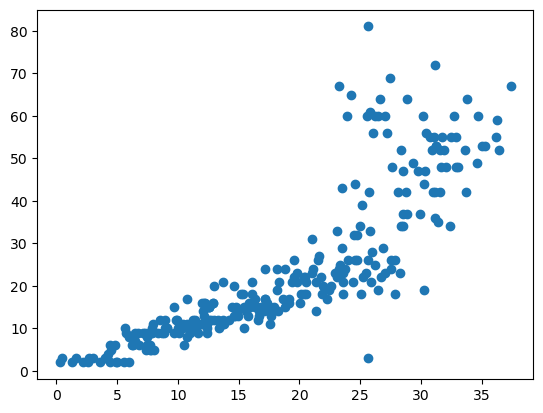

In [8]:
plt.scatter(val_pre_list, val_label_list)
print(len(val_label_list))

Correlation Coefficient: 0.8095865125717379


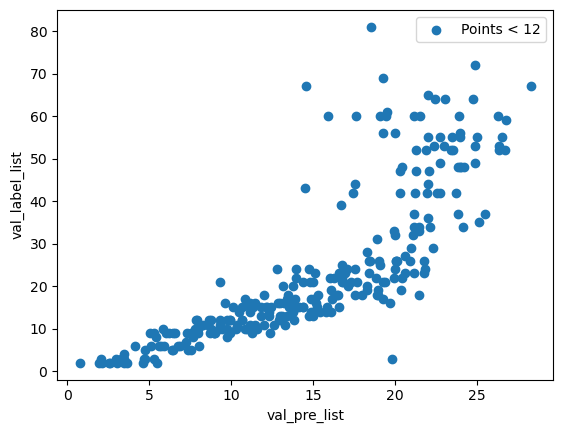

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 val_pre_list 和 val_label_list 是你的预测值和标签列表
val_pre_list = np.array(val_pre_list)
val_label_list = np.array(val_label_list)

# 找出小于 24 的点
filtered_indices = np.where(val_pre_list < 40)

# 获取对应位置的预测值和标签
filtered_val_pre = val_pre_list[filtered_indices]
filtered_val_label = val_label_list[filtered_indices]

# 绘制散点图
plt.scatter(filtered_val_pre, filtered_val_label, label='Points < 12')
plt.xlabel('val_pre_list')
plt.ylabel('val_label_list')
plt.legend()

# 计算相关性
correlation_coefficient, _ = pearsonr(filtered_val_pre, filtered_val_label)
print(f'Correlation Coefficient: {correlation_coefficient}')

# 显示图形
plt.show()


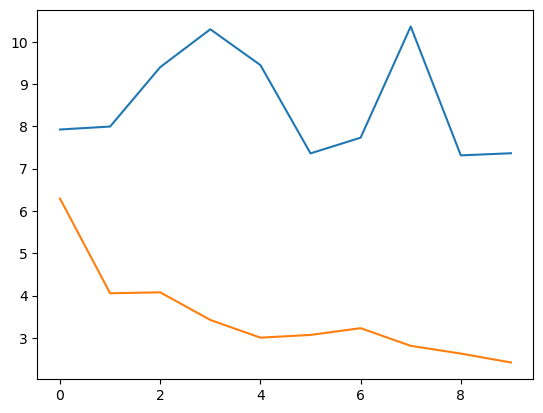

In [9]:
plt.plot(val_loss_list)
plt.plot(train_loss_list)

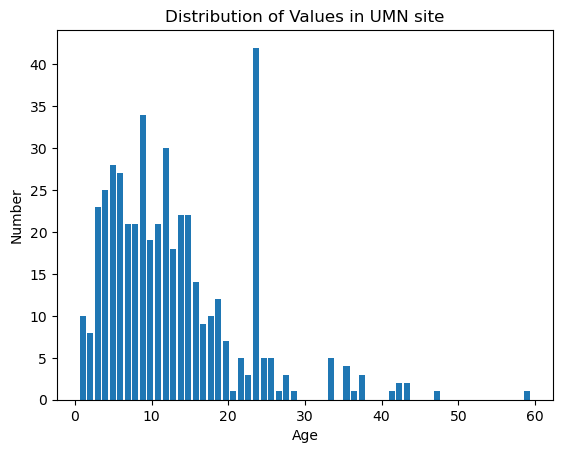

In [48]:
target_list=[]
for batch_idx, (data, target) in enumerate(train_dataloader):
    target_list.append(int(target[0]))

import matplotlib.pyplot as plt

# target_list = [1, 2, 2, 3, 3, 3, 4, 4, 5]

plt.hist(target_list, bins=max(target_list)-min(target_list)+1, align='left', rwidth=0.8)
plt.xlabel('Age')
plt.ylabel('Number')
plt.title('Distribution of Values in UMN site')
plt.show()
